In [55]:
# %%
import pandas as pd
import os 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import itertools
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model

In [ ]:
req_naics = 336111
df = pd.read_csv(f"../data/processed_data_{req_naics}.csv")

In [57]:
import sys
print(sys.version)
print(sys.executable)

3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
/opt/conda/envs/ai_env/bin/python


In [58]:
df.head()

,year,naics,emp,pay,prode,prodh,prodw,vship,matcost,vadd,...,equip,plant,piship,pimat,piinv,pien,dtfp5,tfp5,dtfp4,tfp4
0,1958,336111,146.1,868.4,116.2,229.7,650.6,5007.9,3411.3,1563.8,...,3291.1,11718.8,0.314,0.238,0.180,0.147,NaN,0.553,NaN,0.550
1,1959,336111,160.6,1072.6,131.0,283.2,827.2,6422.2,4306.7,2143.4,...,3457.5,11415.6,0.322,0.243,0.184,0.145,0.052,0.583,0.053,0.580
2,1960,336111,176.1,1183.7,144.7,302.8,925.7,7239.0,4883.5,2336.2,...,3673.0,11375.1,0.318,0.241,0.190,0.150,0.030,0.601,0.030,0.598
3,1961,336111,152.4,1035.7,123.2,252.9,789.5,6214.2,4134.9,2053.6,...,3794.2,11179.9,0.317,0.242,0.190,0.146,-0.007,0.596,-0.009,0.592
4,1962,336111,168.2,1223.6,138.4,297.1,954.7,7855.3,5187.9,2671.2,...,3908.1,11141.2,0.315,0.246,0.193,0.147,0.077,0.644,0.078,0.641


In [59]:
# Convert 'Year' column to datetime if it's not already
df['year'] = pd.to_datetime(df['year'], format='%Y')

# Select the column to decompose (e.g., 'VSHIP' for turnover forecasting)
series = df['vship']  # Replace with the relevant column


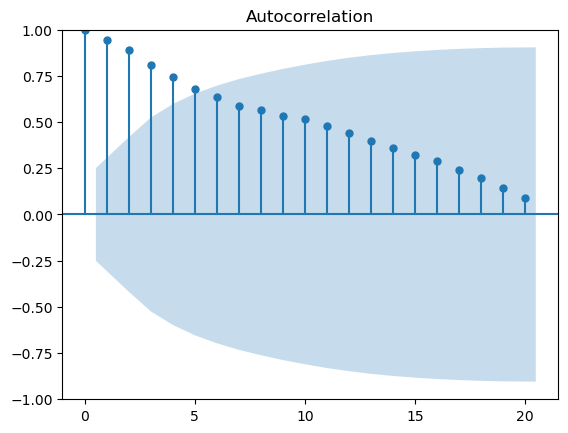

In [60]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series, lags=20)  # See if there’s a peak around lag=12
plt.show()

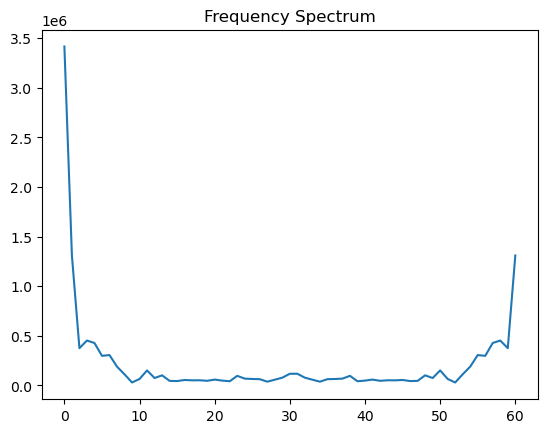

In [61]:
import numpy as np
freq_spectrum = np.fft.fft(series.dropna())
plt.plot(np.abs(freq_spectrum))
plt.title("Frequency Spectrum")
plt.show()

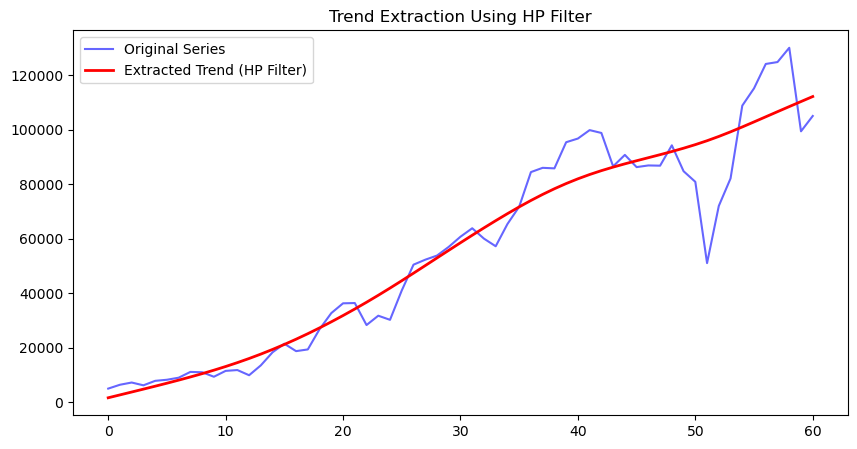

In [62]:
from statsmodels.tsa.filters.hp_filter import hpfilter

# Apply Hodrick-Prescott Filter to extract trend
cycle, trend = hpfilter(series, lamb=1600)  # lambda=1600 is common for annual data

# Plot trend vs original series
plt.figure(figsize=(10, 5))
plt.plot(series, label="Original Series", color="blue", alpha=0.6)
plt.plot(trend, label="Extracted Trend (HP Filter)", color="red", linewidth=2)
plt.legend()
plt.title("Trend Extraction Using HP Filter")
plt.show()

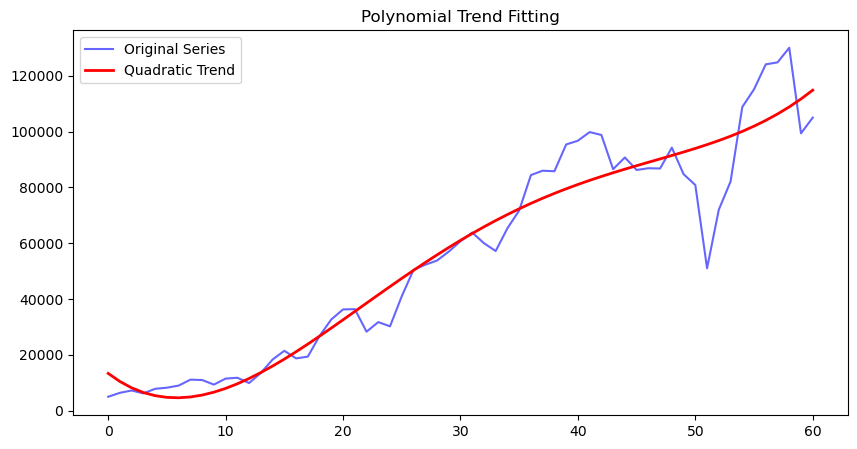

In [63]:
from numpy.polynomial.polynomial import Polynomial
import numpy as np

# Create time index
X = np.arange(len(series))  # Convert years to numerical values
y = series.values

# Fit a 2nd-degree polynomial trend model
p = Polynomial.fit(X, y, deg=4)

# Plot trend
plt.figure(figsize=(10, 5))
plt.plot(series, label="Original Series", color="blue", alpha=0.6)
plt.plot(series.index, p(X), label="Quadratic Trend", color="red", linewidth=2)
plt.legend()
plt.title("Polynomial Trend Fitting")
plt.show()

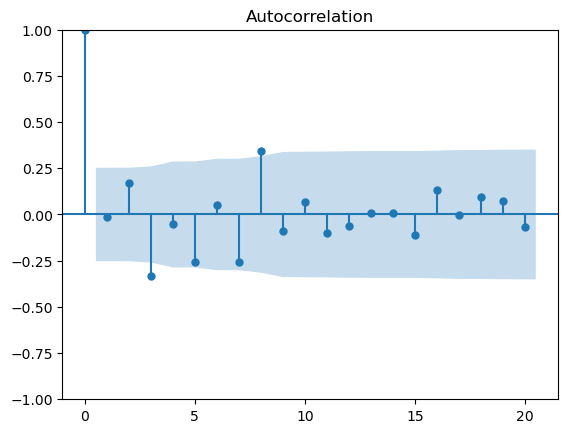

In [64]:
series_diff = series.diff().dropna()

# Recheck ACF after differencing
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series_diff, lags=20)
plt.show()

In [65]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(series_diff)
print(f"ADF Statistic: {adf_result[0]}")
print(f"P-value: {adf_result[1]}")

if adf_result[1] < 0.05:
    print("Series is stationary after differencing.")
else:
    print("Series is still non-stationary, further differencing")

ADF Statistic: -2.6508401487586077
P-value: 0.08293815363262097
Series is still non-stationary, further differencing


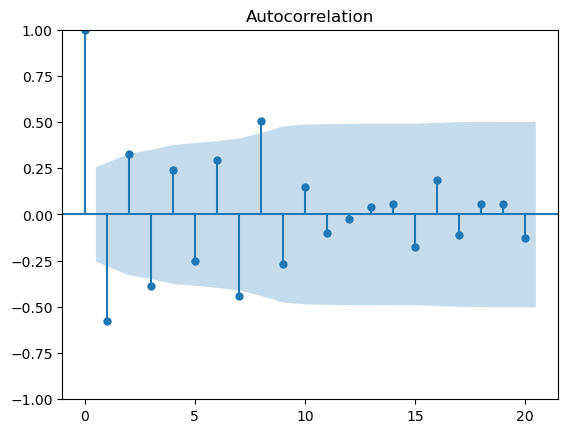

ADF Statistic: -3.862003119437724
P-value: 0.0023329773420767775
Series is now stationary after second differencing.


In [66]:
# Apply second-order differencing
series_diff2 = series.diff().diff().dropna()

# Recheck ACF after second differencing
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series_diff2, lags=20)
plt.show()

# Perform ADF test again
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(series_diff2)
print(f"ADF Statistic: {adf_result[0]}")
print(f"P-value: {adf_result[1]}")

if adf_result[1] < 0.05:
    print("Series is now stationary after second differencing.")
else:
    print("Series is still non-stationary, further transformations may be needed.")


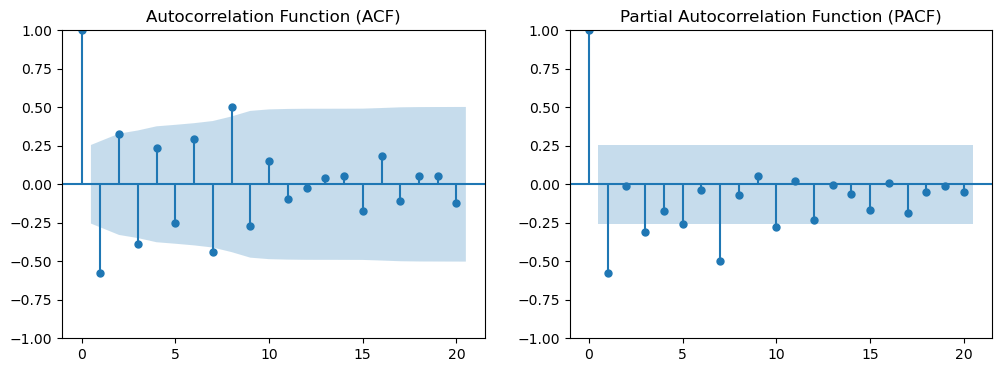

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ACF (for q selection)
sm.graphics.tsa.plot_acf(series.diff().diff().dropna(), lags=20, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF (for p selection)
sm.graphics.tsa.plot_pacf(series.diff().diff().dropna(), lags=20, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()

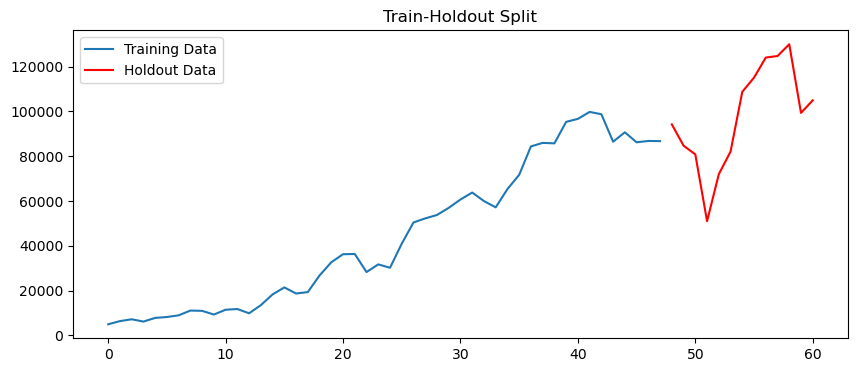

In [68]:
# Assuming 'series' is your Pandas Series with a DateTime index
train_size = int(len(series) * 0.8)  # 80% train, 20% holdout
train, holdout = series.iloc[:train_size], series.iloc[train_size:]

# Plot train/holdout split
plt.figure(figsize=(10, 4))
plt.plot(train, label="Training Data")
plt.plot(holdout, label="Holdout Data", color="red")
plt.title("Train-Holdout Split")
plt.legend()
plt.show()

ARIMA MAE: 15962.390829966775


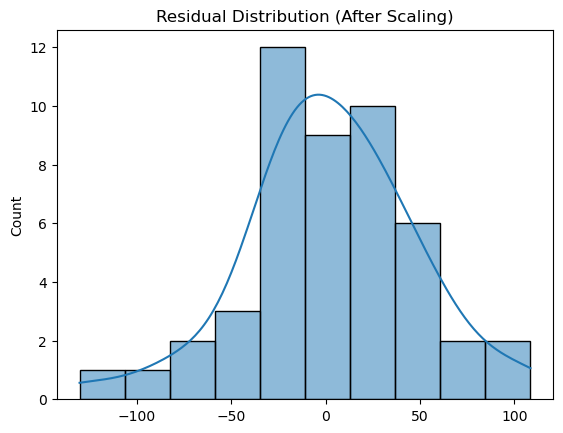

count     48.000000
mean       2.319119
std       45.167189
min     -130.260726
25%      -21.293332
50%        1.484186
75%       26.767801
max      108.551034
dtype: float64


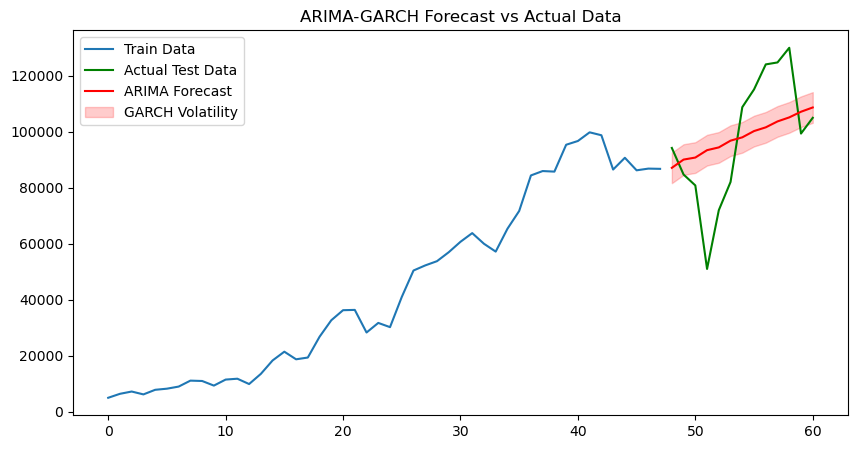

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_absolute_error

# 🔹 Step 1: Train-Test Split (80% Train, 20% Test)
split_idx = int(len(series) * 0.8)  # 80% Train, 20% Test
train, test = series[:split_idx], series[split_idx:]

# 🔹 Step 2: Define ARIMA and GARCH Parameters
p, d, q = 1, 2, 1  # Set based on ACF/PACF analysis
garch_p, garch_q = 1, 1  # GARCH hyperparameters

# 🔹 Step 3: Train ARIMA Model on Full Training Data
arima_model = ARIMA(train, order=(p, d, q))
arima_fit = arima_model.fit()

# 🔹 Step 4: Forecast ARIMA on Test Set
arima_forecast = arima_fit.forecast(steps=len(test))

# 🔹 Step 5: Evaluate ARIMA Model Performance
arima_mae = mean_absolute_error(test, arima_forecast)
print(f"ARIMA MAE: {arima_mae}")

# 🔹 Step 6: Extract ARIMA Residuals
residuals = arima_fit.resid

# Scale residuals to avoid GARCH convergence issues
residuals_scaled = residuals * 0.01  # Recommended rescaling

# Plot histogram of residuals
sns.histplot(residuals_scaled, kde=True)
plt.title("Residual Distribution (After Scaling)")
plt.show()

# Check basic statistics
print(residuals_scaled.describe())

# 🔹 Step 7: Fit GARCH Model on Scaled Residuals
garch_model = arch_model(residuals_scaled, vol='Garch', p=garch_p, q=garch_q)
garch_fit = garch_model.fit(disp="off")

# 🔹 Step 8: Forecast GARCH Volatility
garch_forecast = garch_fit.forecast(horizon=len(test))

# Ensure forecast is valid before extracting variance
if not garch_forecast.variance.empty:
    volatility_forecast = np.sqrt(garch_forecast.variance.iloc[-1].values[0]) / 0.01  # Rescale back
else:
    volatility_forecast = np.zeros(len(test))  # Default if GARCH forecast fails

# 🔹 Step 9: Visualize Results
plt.figure(figsize=(10,5))
plt.plot(train, label="Train Data")
plt.plot(test.index, test, label="Actual Test Data", color="green")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast", color="red")
plt.fill_between(test.index, arima_forecast - volatility_forecast, arima_forecast + volatility_forecast, color='red', alpha=0.2, label="GARCH Volatility")
plt.legend()
plt.title("ARIMA-GARCH Forecast vs Actual Data")
plt.show()


In [74]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test
ljung_box_results = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(ljung_box_results)

     lb_stat  lb_pvalue
10  12.85165   0.232085


Holdout MAE: 15962.390829966775


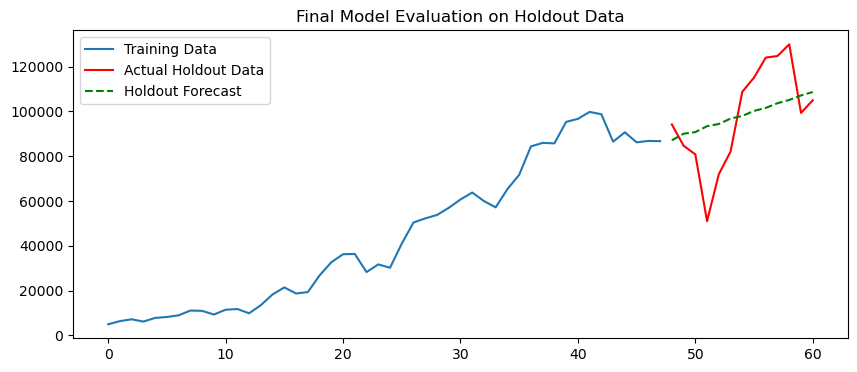

In [70]:
# Train ARIMA on full training set
final_model = ARIMA(train, order=(p, d, q))
final_model_fit = final_model.fit()

# Forecast for Holdout Period
holdout_forecast = final_model_fit.forecast(steps=len(holdout))

# Evaluate performance on holdout set
holdout_mae = mean_absolute_error(holdout, holdout_forecast)
print(f"Holdout MAE: {holdout_mae}")

# Plot Predictions vs Actual
plt.figure(figsize=(10, 4))
plt.plot(train, label="Training Data")
plt.plot(holdout, label="Actual Holdout Data", color="red")
plt.plot(holdout.index, holdout_forecast, label="Holdout Forecast", linestyle="dashed", color="green")
plt.title("Final Model Evaluation on Holdout Data")
plt.legend()
plt.show()

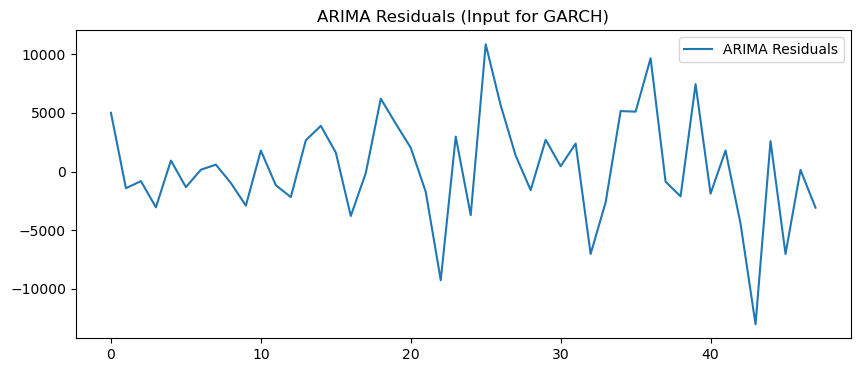

In [71]:
residuals = arima_fit.resid  # Get residuals from ARIMA
plt.figure(figsize=(10, 4))
plt.plot(residuals, label="ARIMA Residuals")
plt.title("ARIMA Residuals (Input for GARCH)")
plt.legend()
plt.show()